# Phase 1: Loading Data, Cleaning, Transformation, & Exploration

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Loading the Data

The training data csv file was too large
to upload to github, so I've uploaded the zip file containing the training and testing set files.  We'll need to extract those files from the zip so we can read them into DataFrames.

In [2]:
with ZipFile('./Data/UNSW_NB15 training and testing sets.zip') as datasets_zip:
    # open each file and read in to a DataFrame
    with datasets_zip.open('UNSW_NB15_training-set.csv') as training_file:
        training_data = pd.read_csv(training_file, index_col='id')
    with datasets_zip.open('UNSW_NB15_testing-set.csv') as testing_file:
        testing_data = pd.read_csv(testing_file, index_col='id')

In [3]:
# if the training files are unzipped, we can load them directly
#training_file = './data/UNSW_NB15_training-set.csv'
#training_data = pd.read_csv(training_file)

### 2. Inspecting the Data Structure

Check out `head`, `info`, `describe` and `hist`ograms to get an idea of what the data looks like.

In [4]:
print(training_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175341 entries, 1 to 175341
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                175341 non-null  float64
 1   proto              175341 non-null  object 
 2   service            175341 non-null  object 
 3   state              175341 non-null  object 
 4   spkts              175341 non-null  int64  
 5   dpkts              175341 non-null  int64  
 6   sbytes             175341 non-null  int64  
 7   dbytes             175341 non-null  int64  
 8   rate               175341 non-null  float64
 9   sttl               175341 non-null  int64  
 10  dttl               175341 non-null  int64  
 11  sload              175341 non-null  float64
 12  dload              175341 non-null  float64
 13  sloss              175341 non-null  int64  
 14  dloss              175341 non-null  int64  
 15  sinpkt             175341 non-null  float64
 16  di

OK, it looks like we've got 175,341 entries and no null values in any column.
There are 44 columns, but I think we can drop the *id* column and we'll want to split off the *label* and *attack_cat*.  
The `object` type features should be strings.

Let's take a quick look at some of the data.

In [5]:
training_data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,
1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


Here we can see that the 4 object type features (*proto*, *service*, *state*, and *attack_cat*) appear to be Strings.  
*attack_cat* is the class we want to learn, factorizing may be a good option for that (one-hot encoding of y labels should use scikit learn `LabelBinarizer`).  
*Label* is either 0 or 1, indicating benign or malicious.

Let's see how many classes there are.

In [6]:
print("There are", training_data['attack_cat'].nunique(), "unique values.")
print("Categories:", training_data['attack_cat'].unique())

There are 10 unique values.
Categories: ['Normal' 'Backdoor' 'Analysis' 'Fuzzers' 'Shellcode' 'Reconnaissance'
 'Exploits' 'DoS' 'Worms' 'Generic']


OK, it looks like 9 classes of Malware, plus 'Normal' benign activity.  
Maybe we can convert the classes to category type and order them so we can look for correlations with other features. Or we can just convert them to an integer sequence instead. We'll come back to that later.

Let's see what those other objects are all about.

In [7]:
print("There are", training_data['proto'].nunique(), "unique values.")
print("Protocols:", training_data['proto'].unique())

There are 133 unique values.
Protocols: ['tcp' 'udp' 'arp' 'ospf' 'icmp' 'igmp' 'rtp' 'ddp' 'ipv6-frag' 'cftp'
 'wsn' 'pvp' 'wb-expak' 'mtp' 'pri-enc' 'sat-mon' 'cphb' 'sun-nd' 'iso-ip'
 'xtp' 'il' 'unas' 'mfe-nsp' '3pc' 'ipv6-route' 'idrp' 'bna' 'swipe'
 'kryptolan' 'cpnx' 'rsvp' 'wb-mon' 'vmtp' 'ib' 'dgp' 'eigrp' 'ax.25'
 'gmtp' 'pnni' 'sep' 'pgm' 'idpr-cmtp' 'zero' 'rvd' 'mobile' 'narp' 'fc'
 'pipe' 'ipcomp' 'ipv6-no' 'sat-expak' 'ipv6-opts' 'snp' 'ipcv'
 'br-sat-mon' 'ttp' 'tcf' 'nsfnet-igp' 'sprite-rpc' 'aes-sp3-d' 'sccopmce'
 'sctp' 'qnx' 'scps' 'etherip' 'aris' 'pim' 'compaq-peer' 'vrrp' 'iatp'
 'stp' 'l2tp' 'srp' 'sm' 'isis' 'smp' 'fire' 'ptp' 'crtp' 'sps'
 'merit-inp' 'idpr' 'skip' 'any' 'larp' 'ipip' 'micp' 'encap' 'ifmp'
 'tp++' 'a/n' 'ipv6' 'i-nlsp' 'ipx-n-ip' 'sdrp' 'tlsp' 'gre' 'mhrp' 'ddx'
 'ippc' 'visa' 'secure-vmtp' 'uti' 'vines' 'crudp' 'iplt' 'ggp' 'ip'
 'ipnip' 'st2' 'argus' 'bbn-rcc' 'egp' 'emcon' 'igp' 'nvp' 'pup' 'xnet'
 'chaos' 'mux' 'dcn' 'hmp' 'prm' 'trunk-1' 

In [8]:
print("There are", training_data['service'].nunique(), "unique values.")
print("Services:", training_data['service'].unique())

There are 13 unique values.
Services: ['-' 'ftp' 'smtp' 'snmp' 'http' 'ftp-data' 'dns' 'ssh' 'radius' 'pop3'
 'dhcp' 'ssl' 'irc']


In [9]:
print("There are", training_data['state'].nunique(), "unique values.")
print("State:", training_data['state'].unique())

There are 9 unique values.
State: ['FIN' 'INT' 'CON' 'ECO' 'REQ' 'RST' 'PAR' 'URN' 'no']


This gives us an idea of what kind of network traffic data we're working with.

Let's look at some histograms of the numeric features.

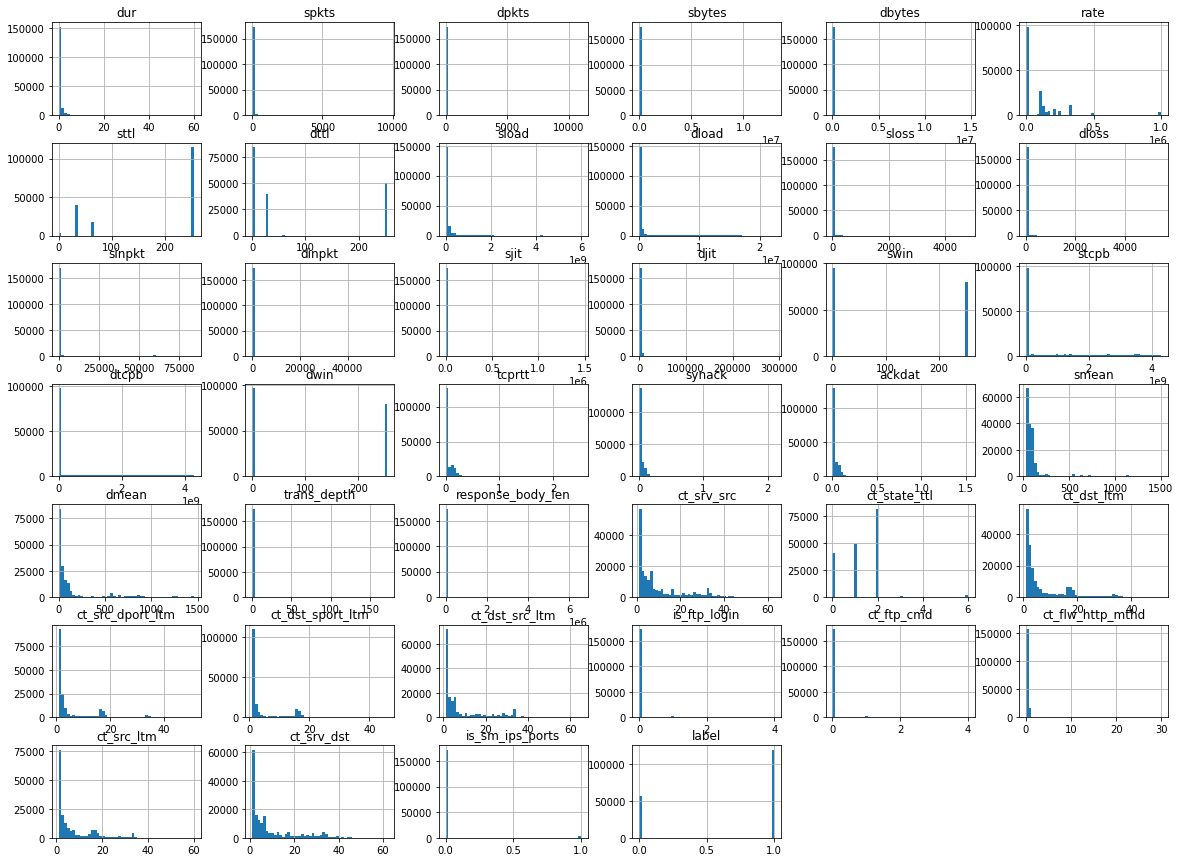

In [10]:
#%matplotlib inline # moved to top of notebook with imports
training_data.hist(bins=50, figsize=(20,15))
plt.show()

We can see that most features have most of their instances at or near zero and relatively few instances at higher values, in some cases much higher. Other features cluster close to zero and have long tails.

Let's see the distribution of labels and classes.

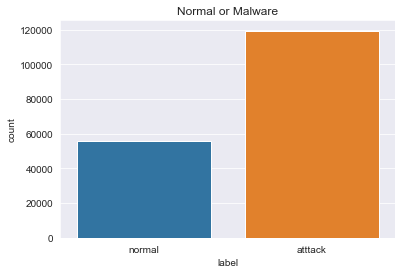

In [11]:
#_ = training_data['label'].value_counts().plot(kind='bar', title='Normal or Malware')
#plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
label_plt = sns.countplot(x='label', data=training_data)
label_plt.set_title('Normal or Malware')
label_plt.set_xticklabels(['normal', 'atttack'])
plt.savefig('./images/label_dist.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
training_data['label'].value_counts()

1    119341
0     56000
Name: label, dtype: int64

Here, 0 represents 'Normal' activity, and 1 is 'Malicious' activity (one of the 9 attack categories). So, we have 56,000 normal instances and 119341 attack instances. Let's so how the attacks break down.

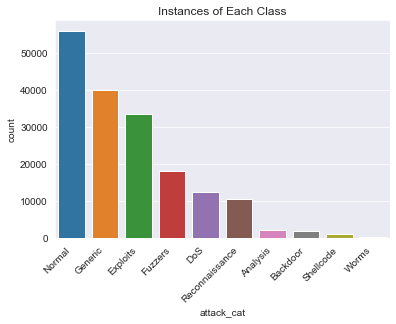

In [13]:
#_ = training_data['attack_cat'].value_counts().plot(kind='bar', title='Instances of Each Class')
desc_cats = training_data['attack_cat'].value_counts().index
sns.set_style('darkgrid')
cat_plt = sns.countplot(x='attack_cat', data=training_data, order=desc_cats)
cat_plt.set_title('Instances of Each Class')
cat_plt.set_xticklabels(cat_plt.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig('./images/cat_dist.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
training_data['attack_cat'].value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

Is there a danger of classification bias with this breakdown (only 130/175,341 instances are worms)?
What could we do to better balance without throwing away most of the data.
On the other hand this data set is probably representative of the percentages of malware in the wild.

### 3. Looking for Correlations and Visualizing

We should calculate data correlations and plot a scatter matrix.

For training the ML models, we'll want to separate the class labels from the rest of the data.  But for investigating correlations, we'll want to include the labels.

In [15]:
correlation_matrix = training_data.corr()

And let's see how the features correlate to the label (normal or attack).  After converting the few categorical features to one-hot there are about 200 features to correlate.

In [16]:
correlation_matrix['label'].sort_values(ascending=False)

label                1.000000
sttl                 0.692741
ct_state_ttl         0.577704
ct_dst_sport_ltm     0.357213
rate                 0.337979
ct_src_dport_ltm     0.305579
ct_dst_src_ltm       0.303855
ct_src_ltm           0.238225
ct_dst_ltm           0.229887
ct_srv_src           0.229044
ct_srv_dst           0.228046
sload                0.182870
ackdat               0.097364
dttl                 0.095049
tcprtt               0.081584
synack               0.058299
dur                  0.036175
sbytes               0.018576
ct_flw_http_mthd     0.015800
trans_depth          0.010801
sloss               -0.000640
sjit                -0.007069
smean               -0.010798
ct_ftp_cmd          -0.011055
is_ftp_login        -0.011055
response_body_len   -0.021361
dinpkt              -0.022887
spkts               -0.052178
djit                -0.060870
dbytes              -0.076871
dloss               -0.094685
dpkts               -0.118591
sinpkt              -0.176110
is_sm_ips_

It seems like a few features (*sttl*, *ct_state_ttl*) have a decent positive correlation to the label (higher values for the malicious label), and a couple are somewhat negatively correlated (*dmean*, *dload*).  
* *sttl* is the source time-to-live value.  
* *ct_state_ttl* is the count for state according to values for time-to-live.  
* *dmean* is the mean of flow packet size transmitted by the destination.  
* *dload* is the number of bits per second from the destination.  

We can look at a heatmap of the correlations of all numeric features to visualize which features are correlated.

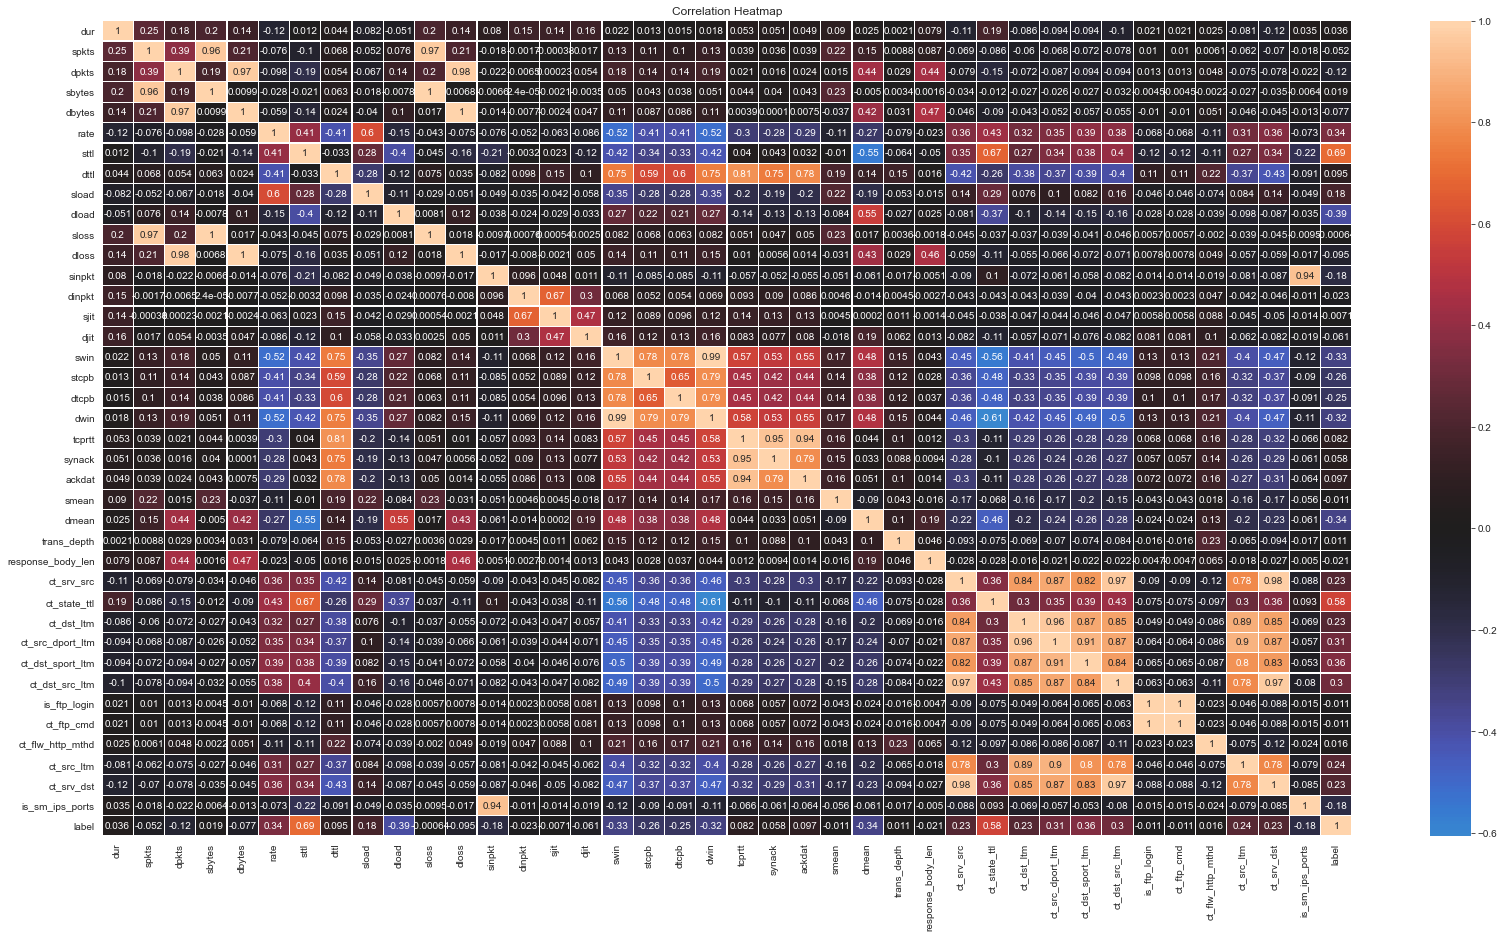

In [17]:
# correlation matrix heatmap
plt.figure(figsize=(28,15))
corr_heatmap = sns.heatmap(correlation_matrix, annot=True, linewidths=0.2, center=0)
corr_heatmap.set_title('Correlation Heatmap')
plt.savefig('./images/corr_heatmap.png', dpi=300, bbox_inches='tight')

We can also check for covariance of features.

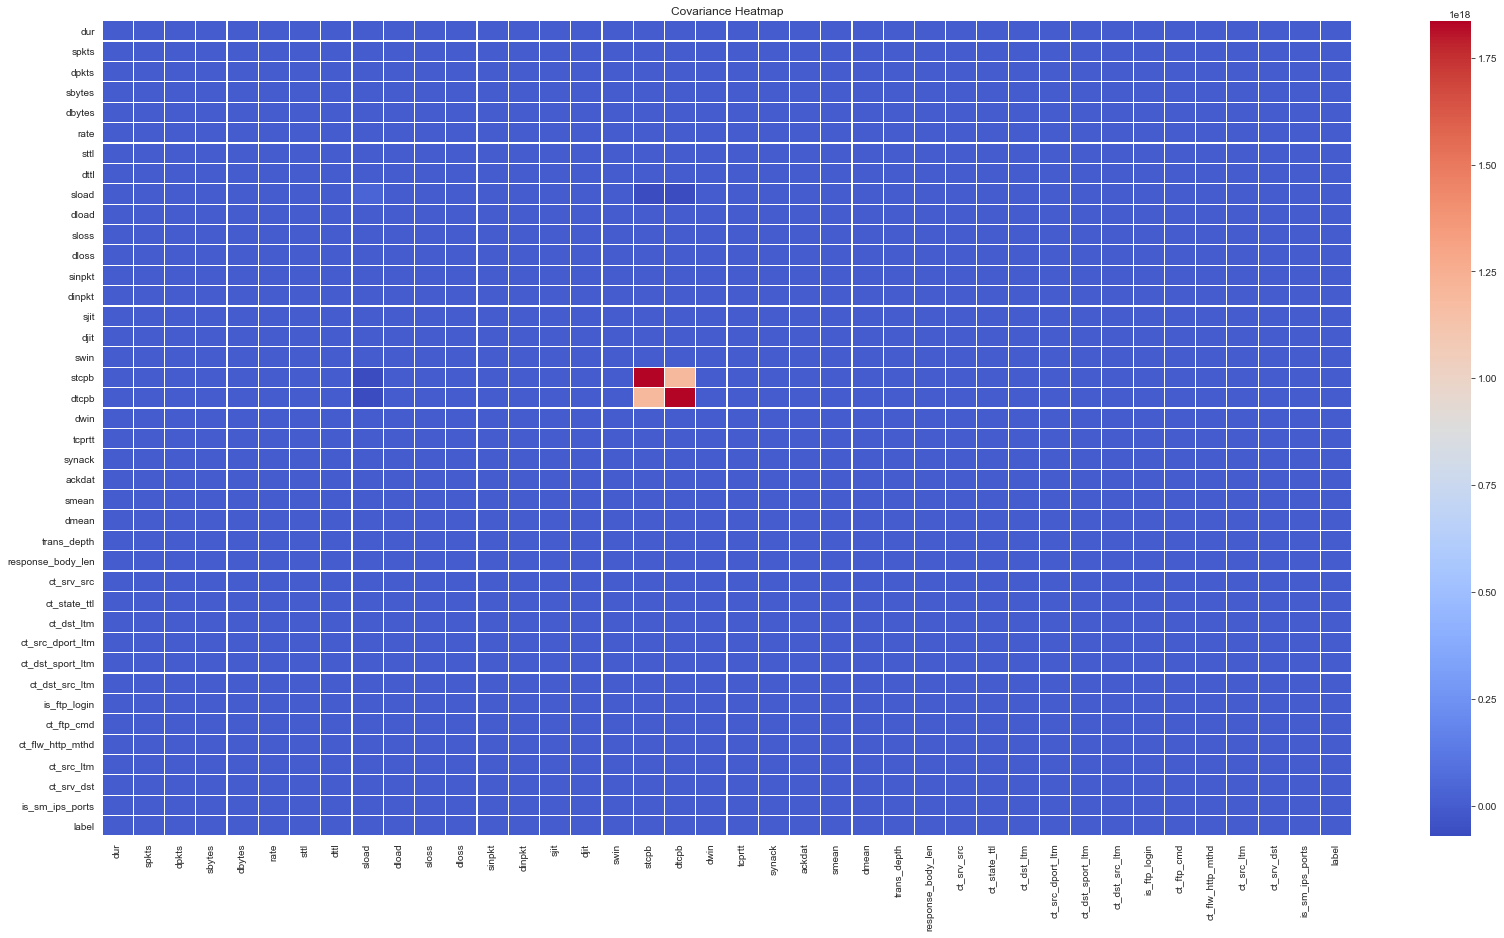

In [18]:
cov_matrix = training_data.cov()
plt.figure(figsize=(28,15))
covar_heatmap = sns.heatmap(data=cov_matrix, cmap='coolwarm', linewidth=0.2) # can we filter this to show only features over a threshold?
covar_heatmap.set_title('Covariance Heatmap')
plt.savefig('./images/covar_heatmap.png', dpi=300, bbox_inches='tight')

In [19]:
#cov_matrix.values > 0.8
#cov_matrix.applymap(lambda x: x>0.8)

Let's check out a scatter matrix of some of these features to better vizualize the correlation.

In [20]:
attrs = ['label', 'sttl', 'ct_state_ttl', 'dmean', 'dload'] #, 'ct_dst_sport_ltm', 'rate', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'dwin', 'swin', 'dmean', 'dload']

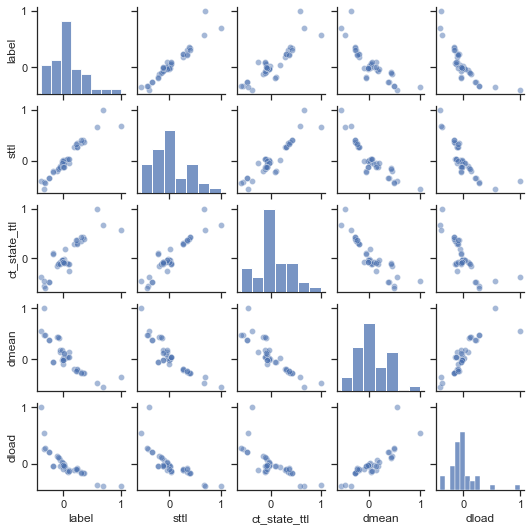

In [21]:
#training_data.plot.scatter()
#_ = scatter_matrix(correlation_matrix, figsize=(12,8))
#import seaborn as sns # added to import block at top of notebook
sns.set(style='ticks', color_codes=True)
_ = sns.pairplot(data=correlation_matrix[attrs], height=1.5, aspect=1, plot_kws={'alpha':0.5})

### 4. ML prep

#### 4.1 Separate labels

Let's separate out the labels from the predicting features.  
We'll also take out the *attack_cat*, since that's what we want to learn.

In [22]:
training = training_data.drop(['label', 'attack_cat'], axis=1)
training_labels = training_data['label'].copy()
training_cats = training_data['attack_cat'].copy()

# whatever we do to the training set should also be done to the testing set
testing = testing_data.drop(['label', 'attack_cat'], axis=1)
testing_labels = testing_data['label'].copy()
testing_cats = testing_data['attack_cat'].copy()

In [23]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175341 entries, 1 to 175341
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                175341 non-null  float64
 1   proto              175341 non-null  object 
 2   service            175341 non-null  object 
 3   state              175341 non-null  object 
 4   spkts              175341 non-null  int64  
 5   dpkts              175341 non-null  int64  
 6   sbytes             175341 non-null  int64  
 7   dbytes             175341 non-null  int64  
 8   rate               175341 non-null  float64
 9   sttl               175341 non-null  int64  
 10  dttl               175341 non-null  int64  
 11  sload              175341 non-null  float64
 12  dload              175341 non-null  float64
 13  sloss              175341 non-null  int64  
 14  dloss              175341 non-null  int64  
 15  sinpkt             175341 non-null  float64
 16  di

In [24]:
training_labels

id
1         0
2         0
3         0
4         0
5         0
         ..
175337    1
175338    1
175339    1
175340    1
175341    1
Name: label, Length: 175341, dtype: int64

In [25]:
training_cats

id
1            Normal
2            Normal
3            Normal
4            Normal
5            Normal
            ...    
175337      Generic
175338    Shellcode
175339      Generic
175340      Generic
175341      Generic
Name: attack_cat, Length: 175341, dtype: object

#### 4.2 Transform Categorical Features

Since these categorical features don't appear to have an inherent ordering, let's try encoding them as one-hot vectors for better ML performance.  
What about the *attack_class*, if we want to do multiclassification on the class we probably need to binarize that as well.

In [26]:
training_data_onehot = pd.get_dummies(training, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])
training_data_onehot.head()

# one-hot the testing set as well
testing_data_onehot = pd.get_dummies(testing, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])

from sklearn import preprocessing
binarizer = preprocessing.LabelBinarizer()
binarized_cats = binarizer.fit_transform(training_cats)
binarizer.classes_

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype='<U14')

In [27]:
training_data_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175341 entries, 1 to 175341
Columns: 194 entries, dur to state_no
dtypes: float64(11), int64(28), uint8(155)
memory usage: 83.5 MB


OK, we still need to deal with the *id*, but this doesn't look too bad.
We went from 45 columns to 195, that shouldn't be too unreasonable for ML.  We also still need to separate the classes/labels and we can probably drop the *id* feature, since it's just a sequential numbering of instances.

#### 4.3 Scale Features

We can check out the statistics for each feature, do they need to be normalized?

In [28]:
#training_data.describe().T
training_data_onehot.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
count,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,...,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,6.712056e+05,...,0.000319,0.075008,0.000068,0.443849,0.469229,0.000006,0.011355,0.000473,0.000006,0.000006
std,6.480249,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,2.421312e+06,...,0.017868,0.263405,0.008272,0.496839,0.499054,0.002388,0.105954,0.021752,0.002388,0.002388
min,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,1.447023e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,2.784487e+04,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We'll probably want to scale these features using normalization or standardization.

In [29]:
from sklearn import preprocessing
training_scaler = preprocessing.StandardScaler().fit(training_data_onehot)
#print(training_scaler.mean_)
#print(training_scaler.scale_)

In [30]:
training_data_standardized = training_scaler.transform(training_data_onehot)
#print(training_data_standardized)
#print(training_data_standardized.mean(axis=0))

In [31]:
print(training_data_standardized.std(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [32]:
training_data_std = pd.DataFrame(training_data_standardized, columns=training_data_onehot.columns)

In [33]:
training_data_std.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
count,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,...,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05
mean,-3.241878e-18,-1.426426e-17,5.187005e-18,-1.053610e-18,1.410217e-17,-3.241878e-17,-1.607972e-16,-1.141141e-16,1.167076e-17,-6.872782e-17,...,5.592240e-18,-3.112203e-17,-4.639938e-18,9.855310e-17,6.483757e-17,-1.347406e-18,3.930777e-18,-2.917690e-18,7.902078e-19,7.902078e-19
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.097747e-01,-1.409822e-01,-1.720474e-01,-5.044967e-02,-1.039229e-01,-5.768192e-01,-1.744196e+00,-7.204059e-01,-3.899726e-01,-2.772081e-01,...,-1.787400e-02,-2.847641e-01,-8.273014e-03,-8.933500e-01,-9.402393e-01,-2.388138e-03,-1.071701e-01,-2.176207e-02,-2.388138e-03,-2.388138e-03
25%,-2.097735e-01,-1.336769e-01,-1.720474e-01,-4.995758e-02,-1.039229e-01,-5.766210e-01,-1.141901e+00,-7.204059e-01,-3.899033e-01,-2.772081e-01,...,-1.787400e-02,-2.847641e-01,-8.273014e-03,-8.933500e-01,-9.402393e-01,-2.388138e-03,-1.071701e-01,-2.176207e-02,-2.388138e-03,-2.388138e-03
50%,-2.095306e-01,-1.336769e-01,-1.539081e-01,-4.814944e-02,-1.027813e-01,-5.573162e-01,7.232680e-01,-4.579780e-01,-3.853023e-01,-2.766105e-01,...,-1.787400e-02,-2.847641e-01,-8.273014e-03,-8.933500e-01,-9.402393e-01,-2.388138e-03,-1.071701e-01,-2.176207e-02,-2.388138e-03,-2.388138e-03
75%,-1.066813e-01,-6.062410e-02,-8.135096e-02,-4.249614e-02,-9.625167e-02,1.789221e-01,7.232680e-01,1.560002e+00,8.194472e-02,-2.657082e-01,...,-1.787400e-02,-2.847641e-01,-8.273014e-03,1.119382e+00,1.063559e+00,-2.388138e-03,-1.071701e-01,-2.176207e-02,-2.388138e-03,-2.388138e-03
max,9.049154e+00,7.009933e+01,9.935819e+01,7.413600e+01,1.019160e+02,5.469112e+00,7.329824e-01,1.578100e+00,3.140074e+01,8.983387e+00,...,5.594720e+01,3.511679e+00,1.208749e+02,1.119382e+00,1.063559e+00,4.187362e+02,9.330959e+00,4.595152e+01,4.187362e+02,4.187362e+02


That should work better, the standard deviation for each feature is 1 and the mean is ~0.  
But should the binary features not change?

## Save transformed data sets for later?

In [34]:
training_data_std.to_pickle("./data/training_data_std.pkl")

## Let's investigate some Feature Selection techniques

In [35]:
# from https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/
from sklearn.feature_selection import SelectKBest, mutual_info_classif
numeric_feat = training.drop(['proto', 'service', 'state'], axis=1)
# the original numeric features, and attack categories; doesn't like binarized categories, needs 1D
info_gain = mutual_info_classif(X=numeric_feat, y=training_cats)

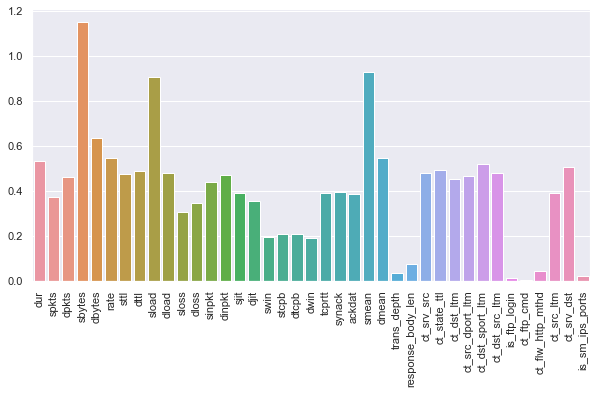

In [36]:
#info_gain
#feat_info_gain = pd.Series(info_gain, numeric_feat.columns)
#feat_info_gain.plot(kind='bar', figsize=(10, 5))
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
ig_plot = sns.barplot(x=numeric_feat.columns, y=info_gain)
ig_plot.set_xticklabels(ig_plot.get_xticklabels(), rotation=90)
plt.savefig('./images/info_gain.png', dpi=300, bbox_inches='tight')
plt.show()

That looks good, we can see that some features provide high information gain, while others hardly any.  
Let's grab the top 10 features using this method.

In [37]:
X_new = SelectKBest(mutual_info_classif, k=10).fit_transform(X=numeric_feat, y=training_cats)
X_new.shape

(175341, 10)

In [38]:
X_new

array([[1.214780e-01, 2.580000e+02, 1.720000e+02, ..., 0.000000e+00,
        1.000000e+00, 1.000000e+00],
       [6.499020e-01, 7.340000e+02, 4.201400e+04, ..., 1.000000e+00,
        1.000000e+00, 6.000000e+00],
       [1.623129e+00, 3.640000e+02, 1.318600e+04, ..., 1.000000e+00,
        1.000000e+00, 6.000000e+00],
       ...,
       [9.000000e-06, 1.140000e+02, 0.000000e+00, ..., 2.000000e+00,
        3.000000e+00, 1.200000e+01],
       [9.000000e-06, 1.140000e+02, 0.000000e+00, ..., 2.000000e+00,
        1.400000e+01, 3.000000e+01],
       [9.000000e-06, 1.140000e+02, 0.000000e+00, ..., 2.000000e+00,
        1.600000e+01, 3.000000e+01]])

### work continues...

In [52]:
# slice off as many as needed from this list
ig_list = list(zip(numeric_feat, info_gain))
ig_list_desc = sorted(ig_list, reverse=True, key=lambda x:x[1])
print(ig_list_desc)

[('sbytes', 1.150484535294778), ('smean', 0.9291439353711257), ('sload', 0.905486366268357), ('dbytes', 0.6378037066163769), ('rate', 0.5495764803830157), ('dmean', 0.5488064016817495), ('dur', 0.5358853843007889), ('ct_dst_sport_ltm', 0.522509449085093), ('ct_srv_dst', 0.5095687671848652), ('ct_state_ttl', 0.49227242660303405), ('dttl', 0.4902537376647045), ('dload', 0.48209737080488635), ('ct_srv_src', 0.4807657052761707), ('ct_dst_src_ltm', 0.4804097734118473), ('sttl', 0.475020600501471), ('dinpkt', 0.4740294068383939), ('ct_src_dport_ltm', 0.4685288874713258), ('dpkts', 0.4633541747359109), ('ct_dst_ltm', 0.4553665399080229), ('sinpkt', 0.44122407639266115), ('synack', 0.396033728518002), ('tcprtt', 0.39402455239810497), ('ct_src_ltm', 0.3919029515582175), ('sjit', 0.3907328534256971), ('ackdat', 0.38778331297845003), ('spkts', 0.3738225261763932), ('djit', 0.35607740602835847), ('dloss', 0.3471887131375868), ('sloss', 0.3061611687233712), ('stcpb', 0.20976397105241862), ('dtcpb',

Let's try some other methods now

In [54]:
# Fisher Score
# open source library scikit-feature, here: https://github.com/jundongl/scikit-feature
from skfeature.function.similarity_based import fisher_score
fscores = fisher_score.fisher_score(X=numeric_feat, y=training_cats)

plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
fs_plot = sns.barplot(x=numeric_feat.columns, y=fscores)
fs_plot.set_xticklabels(fs_plot.get_xticklabels(), rotation=90)
plt.savefig('./images/fisher_scores.png', dpi=300, bbox_inches='tight')
plt.show()

c:\users\phil\appdata\local\programs\python\python38\lib\site-packages\skfeature\utility\construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])


MemoryError: Unable to allocate 28.6 GiB for an array with shape (175341, 175341) and data type bool

In [56]:
# compute ANOVA f-value
from sklearn.feature_selection import f_classif
f_value = f_classif(X=numeric_feat, y=training_cats)

#plt.figure(figsize=(10,5))
#sns.set_style('darkgrid')
#anova_plot = sns.barplot(x=numeric_feat.columns, y=f_value)
#anova_plot.set_xticklabels(anova_plot.get_xticklabels(), rotation=90)
#plt.savefig('./images/anova_fvalues.png', dpi=300, bbox_inches='tight')
#plt.show()

In [58]:
f_value[0] # f-values

array([4.47536170e+02, 1.63811530e+02, 3.75416966e+02, 6.82645767e+01,
       1.60517590e+02, 5.40323576e+03, 2.41397590e+04, 7.21638416e+03,
       9.40201468e+02, 3.57593358e+03, 7.77910341e+01, 2.40783491e+02,
       6.28676193e+02, 1.40515741e+02, 3.07787103e+02, 2.23577892e+02,
       8.84198681e+03, 4.54121825e+03, 4.53531142e+03, 8.48467294e+03,
       3.74925917e+03, 3.11200700e+03, 3.54198070e+03, 1.63956630e+03,
       3.84449674e+03, 2.58857114e+02, 2.26185460e+01, 4.15248301e+04,
       1.20590421e+04, 3.37062592e+04, 4.33893572e+04, 7.96689785e+04,
       4.40994588e+04, 3.34334557e+02, 3.34334557e+02, 1.46974587e+03,
       2.15389029e+04, 4.36802056e+04, 6.87898459e+02])

In [59]:
anova_list = list(zip(numeric_feat, f_value[0]))
anova_list_desc = sorted(anova_list, reverse=True, key=lambda x:x[1])
print(anova_list_desc)

[('ct_dst_sport_ltm', 79668.97851098045), ('ct_dst_src_ltm', 44099.458769833094), ('ct_srv_dst', 43680.20560695667), ('ct_src_dport_ltm', 43389.35723958356), ('ct_srv_src', 41524.83005719872), ('ct_dst_ltm', 33706.25921546025), ('sttl', 24139.75903719711), ('ct_src_ltm', 21538.902873327563), ('ct_state_ttl', 12059.04209559811), ('swin', 8841.986805416283), ('dwin', 8484.672935877), ('dttl', 7216.38415755441), ('rate', 5403.235762771765), ('stcpb', 4541.218248328995), ('dtcpb', 4535.311419078794), ('dmean', 3844.4967387787515), ('tcprtt', 3749.2591730117465), ('dload', 3575.933584603727), ('ackdat', 3541.9806997245505), ('synack', 3112.006998976731), ('smean', 1639.5662983861364), ('ct_flw_http_mthd', 1469.745868443294), ('sload', 940.2014682918722), ('is_sm_ips_ports', 687.8984585180172), ('sinpkt', 628.6761931199068), ('dur', 447.5361697212745), ('dpkts', 375.4169663706858), ('is_ftp_login', 334.3345568271812), ('ct_ftp_cmd', 334.3345568271812), ('sjit', 307.7871029504711), ('trans_de

In [66]:
top10ig = [x[0] for x in ig_list_desc[:10]]
top10anova = [x[0] for x in anova_list_desc[:10]]
pd.DataFrame(list(zip(top10ig, top10anova)), columns=['IG', 'F'])

,IG,F
0,sbytes,ct_dst_sport_ltm
1,smean,ct_dst_src_ltm
2,sload,ct_srv_dst
3,dbytes,ct_src_dport_ltm
4,rate,ct_srv_src
5,dmean,ct_dst_ltm
6,dur,sttl
7,ct_dst_sport_ltm,ct_src_ltm
8,ct_srv_dst,ct_state_ttl
9,ct_state_ttl,swin


IG with one-hot features added

In [70]:
info_gain_full = mutual_info_classif(X=training_data_onehot, y=training_cats)

In [76]:
ig_full_list_desc = sorted(list(zip(training_data_onehot.columns, info_gain_full)), reverse=True, key=lambda x:x[1])

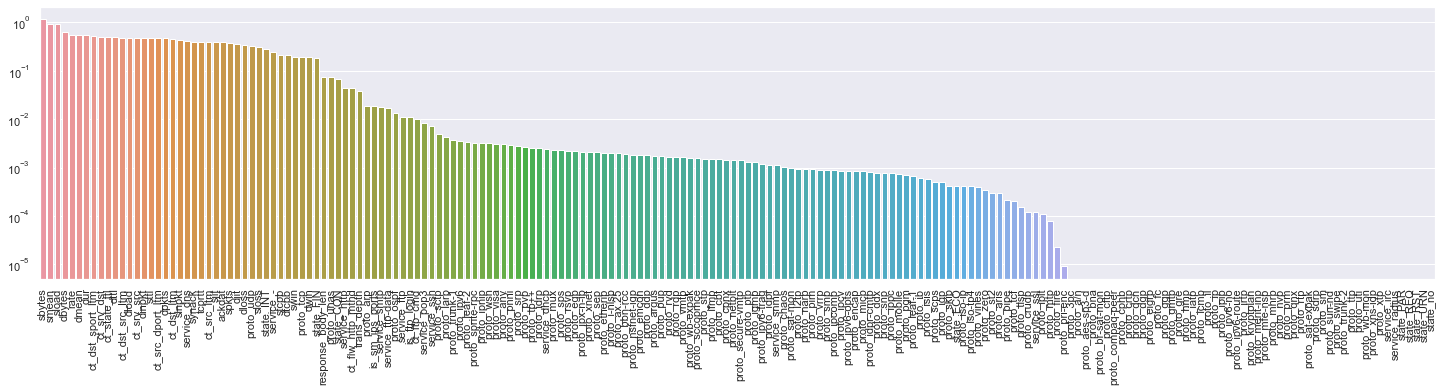

In [78]:
#training_data['attack_cat'].value_counts().index
plt.figure(figsize=(25,5))
sns.set_style('darkgrid')
ig_full_plot = sns.barplot(x=training_data_onehot.columns, y=info_gain_full, order=[x[0] for x in ig_full_list_desc])
ig_full_plot.set_xticklabels(ig_full_plot.get_xticklabels(), rotation=90)
ig_full_plot.set_yscale('log')  # let's see more values
plt.savefig('./images/info_gain_full.png', dpi=300, bbox_inches='tight')
plt.show()